# RL training on the env

In [1]:
import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_density, geom_line, geom_point, 
    geom_violin, facet_grid, labs, theme, facet_wrap,
)

# for rl training
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC
from stable_baselines3.common.env_util import make_vec_env

# the rl environment
from rl4greencrab import greenCrabSimplifiedEnv as gcse

# helper that paralelizes episode simulations for evaluation purposes (agent -> reward)
from rl4greencrab import evaluate_agent

# helper that creates a single episode simulation keeping track of many variables
# of the internal env state
from rl4greencrab import simulator
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
# using 'vectorized environments' helps paralelize RL training
# (the RL agent collects data by simultaneously interacting with
# n_envs different environments, rather than doing it one envir.
# at a time.
vec_env = make_vec_env(gcse, n_envs=12)

## Algo 1: PPO

see docs here: https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html

In [3]:
model = PPO("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("ppo_gcse")

Output()

## Algo 2: TD3

In [ ]:
model = TD3("MlpPolicy", gcse, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("td3_gcse")

## Algo 3: TQC

In [7]:
model = TQC("MlpPolicy", vec_env, verbose=0, tensorboard_log="/home/rstudio/logs")
model.learn(
	total_timesteps=250_000, 
	progress_bar=True,
)
model.save("tqc_gcse")

Output()

## Loading and evaluating trained models

In [4]:
# load agents into the CPU (rather than the GPU - the default)
# since the paralelization we use to evaluate agents works with
# CPU

ppoAgent = PPO.load("ppo_gcse", device="cpu")
# td3Agent = TD3.load("td3_gcse", device="cpu")
tqcAgent = TQC.load("tqc_gcse", device="cpu")
evalEnv = gcse()

/opt/conda/lib/python3.11/site-packages/stable_baselines3/common/save_util.py:167: UserWarning: Could not deserialize object lr_schedule. Consider using `custom_objects` argument to replace this object.
Exception: code() argument 13 must be str, not int


In [5]:
mean_rew, std_rew = evaluate_policy(ppoAgent, evalEnv)
print(f"PPO reward = {mean_rew:.5f} +/- {std_rew:.5f}")

/opt/conda/lib/python3.11/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.


PPO reward = -12.12830 +/- 1.54197


In [6]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
ppoDataDF.head()

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.000000,-1.000000,-0.293893,-0.200729,-0.139028,0.000000,0
1,1,-1.000000,-1.000000,-0.293893,-0.200729,-0.139028,-0.003313,0
2,2,-0.999949,-0.998631,-0.293828,-0.200681,-0.139004,-0.011676,0
3,3,-0.996459,-0.995690,-0.293370,-0.200386,-0.138839,-0.028878,0
4,4,-0.994019,-0.994027,-0.293066,-0.200193,-0.138730,-0.084550,0


<Axes: xlabel='t'>

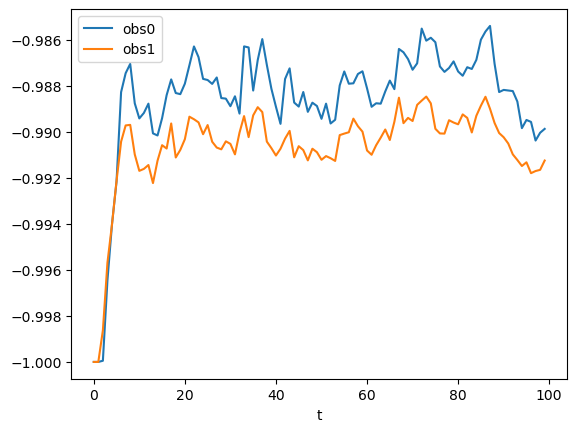

In [7]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0', 'obs1'])

In [13]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
# td3_rew = evaluate_agent(agent=td3Agent, ray_remote=True).evaluate(n_eval_episodes=N_EPS)
tqc_rew = evaluate_agent(agent=tqcAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

In [15]:
import ray
ray.shutdown()

In [16]:
print(f"""
PPO mean rew = {ppo_rew}
TQC mean rew = {tqc_rew}
""")


PPO mean rew = -9.576186668916746
TQC mean rew = -6.698807471424942

